### Roadmap
- Collect data into usable format
- show graphs
- some understanding of data > move to H testing
- interpret etc

This notebook mirrors the README but with a bit more detail

#### Data source
This data comes from public sources: 
- the LA metro bike share (https://bikeshare.metro.net/about/data/) 
- the Chicago divvy bike share (https://www.divvybikes.com/system-data)

Files can be downloaded as .zip and once unzipped are .csv. A couple Chicago files are not named .csv correctly and must be renamed manually before this script can interpret them correctly. This script does not download or unzip these files.

In [1]:
# Imports and dependencies. This EDA uses Spark

import pyspark as ps
from pyspark.sql.types import *
import pyspark.sql.functions as f
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.nonparametric.smoothers_lowess import lowess
plt.style.use('ggplot')

import bike_eda

# Most bike_eda.py functions use this spark session
spark = (ps.sql.SparkSession.builder 
        .master("local[4]") 
        .appName("morning sprint") 
        .getOrCreate()
        )

sc = spark.sparkContext

Below we can see the format of our data. There is some useful information in here! We'll only get to explore a couple things in this EDA.

In [2]:
# First we want to get the data from our csv files. Let's start with LA

la_sdf = bike_eda.la_csv_to_sdf(spark)

la_sdf.show(1)

+--------+--------+-------------------+-------------------+-------------+---------+----------+-----------+--------+----------+-------+-------------+-------------------+---------------+
| trip_id|duration|         start_time|           end_time|start_station|start_lat| start_lon|end_station| end_lat|   end_lon|bike_id|plan_duration|trip_route_category|passholder_type|
+--------+--------+-------------------+-------------------+-------------+---------+----------+-----------+--------+----------+-------+-------------+-------------------+---------------+
|94851140|       8|2018-07-01 00:04:00|2018-07-01 00:12:00|         3058|  34.0358|-118.23317|       3082|34.04652|-118.23741|   6279|           30|            One Way|   Monthly Pass|
+--------+--------+-------------------+-------------------+-------------+---------+----------+-----------+--------+----------+-------+-------------+-------------------+---------------+
only showing top 1 row



The only missing data is a chunk of lattitude and longitude coordinates and a small number of missing bike IDs. It's likely there are some stations that don't have that information for whatever reason. Because the rest of the row still has data and we aren't using geographic data, we won't worry about those rows.

In [9]:
# How much missing data is in each column

la_sdf.select([f.count(f.when(f.isnull(c), c)).alias(c) for c in la_sdf.columns]).show()

+-------+--------+----------+--------+-------------+---------+---------+-----------+-------+-------+-------+-------------+-------------------+---------------+
|trip_id|duration|start_time|end_time|start_station|start_lat|start_lon|end_station|end_lat|end_lon|bike_id|plan_duration|trip_route_category|passholder_type|
+-------+--------+----------+--------+-------------+---------+---------+-----------+-------+-------+-------+-------------+-------------------+---------------+
|      0|       0|         0|       0|            0|    50254|    50254|          0|  24649|  24649|     11|            0|                  0|              0|
+-------+--------+----------+--------+-------------+---------+---------+-----------+-------+-------+-------+-------------+-------------------+---------------+



Now let's move on to a visualization so we can get a sense of the shape of the data. One graph that's easy to interpret is the number of rides taken each month for different years.

You can see 2018 and 2019 follow a pretty basic pattern but 2020 really falls flat after COVID starts to take it's hold and societal changes roll in.

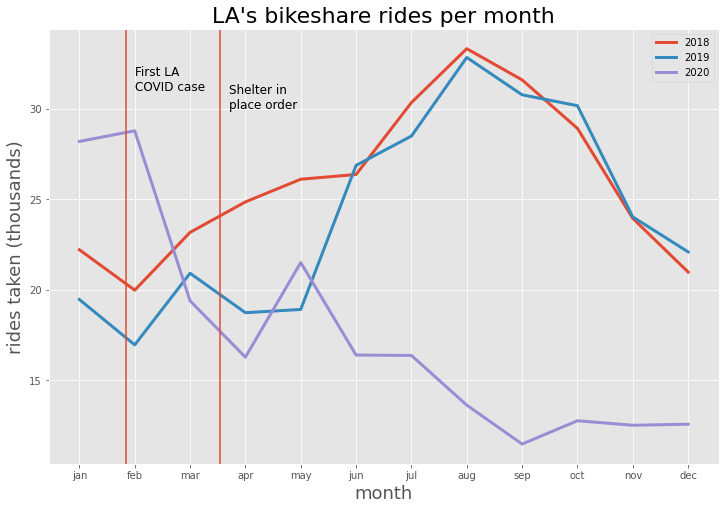

In [3]:
# Many of these cells take a minute to run, there is a lot of data to look through

fig, ax = plt.subplots(figsize=(12,8))

bike_eda.la_month_graph(spark, ax, hline=True)

Let's look at Chicago during the same time period.

The features of the data are similar to LA's and there is no missing data to note, so we'll jump straight to the visualization.

While Chicago certainly has a dip a couple months into 2020, they appear to recover and even exceed their 2019 numbers by fall. By looking at the scale of rides taken you can also tell Chicago's program is much bigger. Even in the dead of winter more bikes are being riden than in LA's peak season.

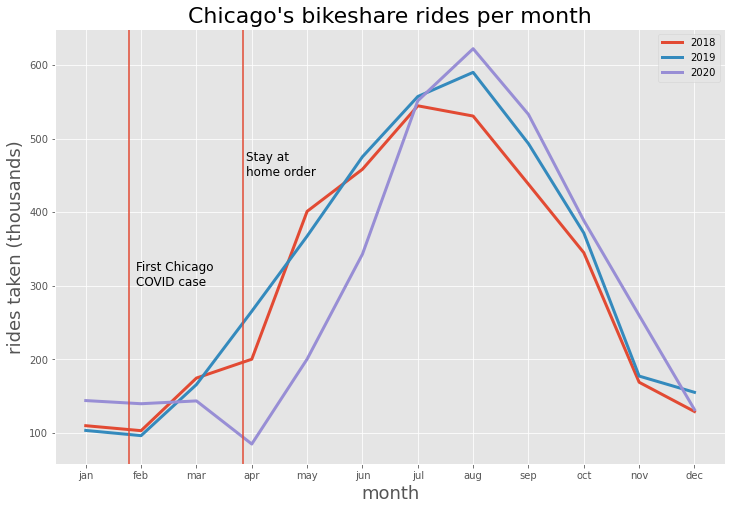

In [4]:
# Many of these cells take a minute to run, there is a lot of data to look through

fig, ax = plt.subplots(figsize=(12,8))

bike_eda.ch_month_graph(spark, ax, hline=True)

It's not hard to see what's going on visually with these two cities but we should run some statistical tests for two reasons: One, we can back up any specific findings with math. Two, if we want to analyze other cities where the impact may not be as clear we have a precedent for analyzing it methodically.

So let's decide on some measurement we want to compare and then what specific tests we want to run.

Daily ride counts are a decent measurement, there's 365 observations in a year and it's easy to interpret. We could compare the entire year 2019 to 2020, but I want to get more granular. It looks like cities felt the impact from COVID but that Chicago recovers, let's test that out by slicing up the year. The pandemic starting taking effect roughly around the border between quarter 1 (January to March) and quarter 2 (April to Jun). So by comparing Q1 and Q2 we can measure the initial impact of COVID. By next comparing Q2 to Q3 we can measure some of the long term effects of COVID.

One important step: daily ride counts already vary wildly between winter and summer because of the weather. We can normalize this by taking a day-by-day difference score from 2019 to 2020 (ie 2019-01-01 minus 2020-01-01, one for each day). This is again a normalized spread of how 2020 has grown as compared to 2019. Using these difference scores, instead of raw ride counts, we can compare different quarters without the interference of the seasons. 

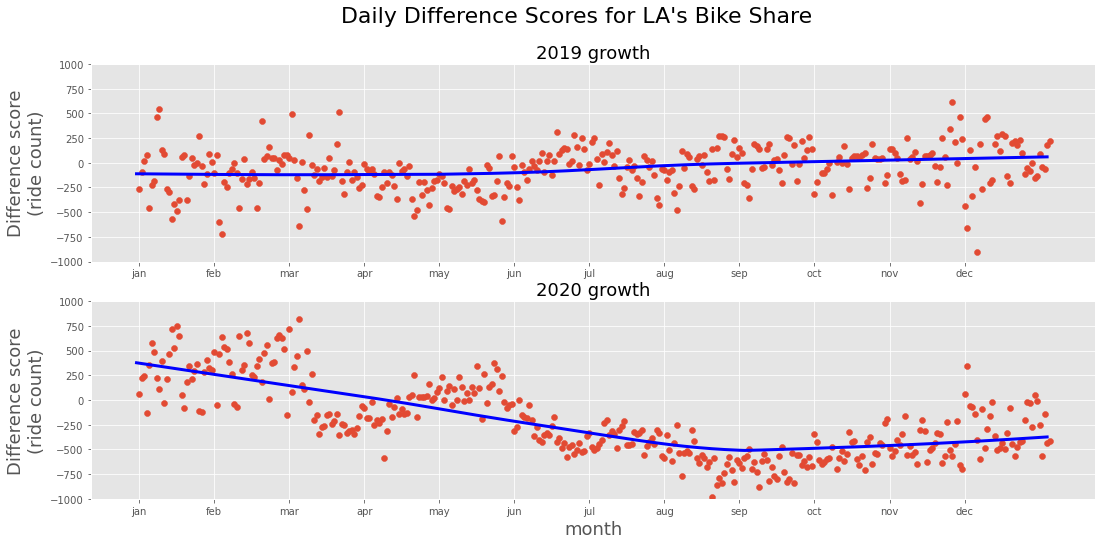

In [2]:
# Get the difference score graphs

fig, (ax1, ax2) = plt.subplots(2, figsize=(18,8))

bike_eda.la_diff_graph(spark, fig, ax1, ax2)

In [ ]:
# make a graph of chicago just 2020 growth
# partition different quarters and explain hypothesis test comparisons
# make 4 quarter func
# make p-values (but print out nicely, no test stat)